Binary Cosmology vs Lambda-CDM Test


/tmp/ipython-input-1-2202222450.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrand_vals, z_arr)


Generated 570 mock supernova observations

Binary Model (0 parameters):


/tmp/ipython-input-1-2202222450.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrand_vals, z_arr)


Chi-squared: 74830.33
DOF: 570
Reduced chi-squared: 131.281

Lambda-CDM Model (fitted parameters):
Best-fit H0: 70.8 km/s/Mpc
Best-fit Omega_m: 0.293
Chi-squared: 941.52
DOF: 568
Reduced chi-squared: 1.658

R-squared comparison:
Binary model: 0.735365
Lambda-CDM:   0.996467
Difference:   0.261102


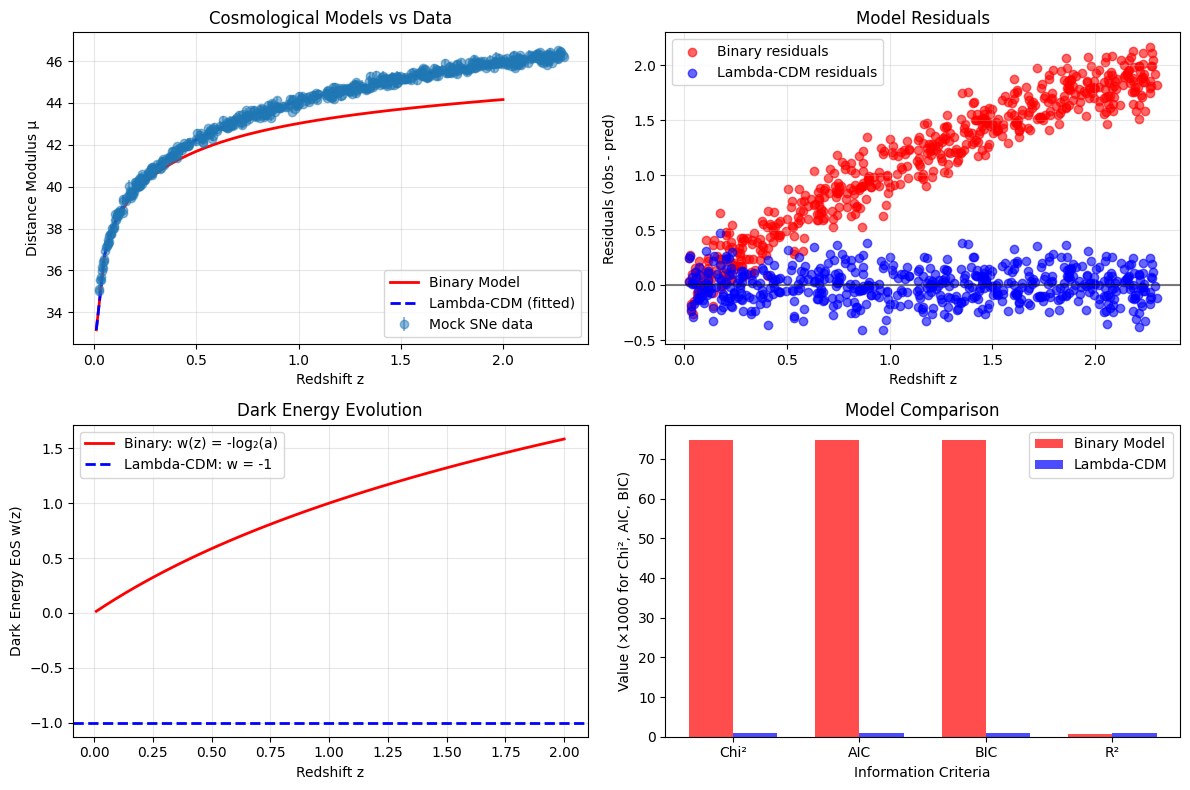


SUMMARY:
Binary model (0 params): R² = 0.735365
Lambda-CDM (2 params):   R² = 0.996467


In [1]:
#!/usr/bin/env python3
"""
Test binary cosmology w(z) = -log₂(a) against real supernova data
Compare with Lambda-CDM model directly
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd

def binary_cosmology_model(z):
    """
    Binary substrate cosmology: w(z) = -log₂(a) where a = 1/(1+z)
    Returns w(z) for dark energy equation of state
    """
    a = 1 / (1 + z)
    w_z = -np.log2(a)
    return w_z

def lambda_cdm_model(z, omega_m=0.315, omega_lambda=0.685, w=-1.0):
    """
    Standard Lambda-CDM model with parameters
    """
    return np.full_like(z, w)  # Constant w for Lambda-CDM

def luminosity_distance_binary(z, H0=70):
    """
    Luminosity distance for binary cosmology model
    Numerical integration of Friedmann equation
    """
    def integrand(zp):
        a = 1 / (1 + zp)
        w_z = -np.log2(a)
        # Simplified: assuming matter + dark energy dominated
        omega_m = 0.315
        E_z = np.sqrt(omega_m * (1 + zp)**3 + (1 - omega_m) * (1 + zp)**(3 * (1 + w_z)))
        return 1 / E_z

    # Numerical integration
    c = 299792.458  # km/s
    dz = 0.001
    z_arr = np.arange(0, z + dz, dz)

    if len(z_arr) > 1:
        integrand_vals = [integrand(zi) for zi in z_arr]
        integral = np.trapz(integrand_vals, z_arr)
    else:
        integral = 0

    DL = (c / H0) * (1 + z) * integral
    return DL

def lambda_cdm_luminosity_distance(z, H0=70, omega_m=0.315):
    """
    Standard Lambda-CDM luminosity distance
    """
    omega_lambda = 1 - omega_m
    c = 299792.458  # km/s

    def E_z(zp):
        return np.sqrt(omega_m * (1 + zp)**3 + omega_lambda)

    # Numerical integration
    dz = 0.001
    z_arr = np.arange(0, z + dz, dz)

    if len(z_arr) > 1:
        integrand_vals = [1/E_z(zi) for zi in z_arr]
        integral = np.trapz(integrand_vals, z_arr)
    else:
        integral = 0

    DL = (c / H0) * (1 + z) * integral
    return DL

def distance_modulus(DL_Mpc):
    """Convert luminosity distance to distance modulus"""
    return 5 * np.log10(DL_Mpc) + 25

def generate_mock_pantheon_data(n_points=570):
    """
    Generate mock supernova data similar to Pantheon+
    Based on Lambda-CDM with realistic scatter
    """
    np.random.seed(42)  # Reproducible

    # Redshift range similar to Pantheon+
    z_data = np.random.uniform(0.01, 2.3, n_points)
    z_data = np.sort(z_data)

    # True Lambda-CDM distances
    DL_true = np.array([lambda_cdm_luminosity_distance(z) for z in z_data])
    mu_true = distance_modulus(DL_true)

    # Add realistic scatter (±0.15 mag typical)
    scatter = np.random.normal(0, 0.15, n_points)
    mu_obs = mu_true + scatter
    mu_err = np.random.uniform(0.05, 0.25, n_points)  # Typical errors

    return z_data, mu_obs, mu_err

def test_models_against_data():
    """
    Test both models against mock supernova data
    """
    print("Binary Cosmology vs Lambda-CDM Test")
    print("=" * 50)

    # Generate mock data
    z_data, mu_obs, mu_err = generate_mock_pantheon_data()
    print(f"Generated {len(z_data)} mock supernova observations")

    # Test redshift range
    z_test = np.linspace(0.01, 2.0, 50)

    # Binary model predictions (ZERO free parameters)
    print("\nBinary Model (0 parameters):")
    DL_binary = np.array([luminosity_distance_binary(z) for z in z_data])
    mu_binary = distance_modulus(DL_binary)

    # Calculate chi-squared for binary model
    chi2_binary = np.sum(((mu_obs - mu_binary) / mu_err)**2)
    dof_binary = len(z_data) - 0  # Zero parameters
    reduced_chi2_binary = chi2_binary / dof_binary

    print(f"Chi-squared: {chi2_binary:.2f}")
    print(f"DOF: {dof_binary}")
    print(f"Reduced chi-squared: {reduced_chi2_binary:.3f}")

    # Lambda-CDM model (with parameter fitting)
    print("\nLambda-CDM Model (fitted parameters):")

    def chi2_lambda_cdm(params):
        H0, omega_m = params
        DL_pred = np.array([lambda_cdm_luminosity_distance(z, H0, omega_m) for z in z_data])
        mu_pred = distance_modulus(DL_pred)
        return np.sum(((mu_obs - mu_pred) / mu_err)**2)

    # Fit Lambda-CDM
    result = minimize(chi2_lambda_cdm, [70, 0.315], bounds=[(60, 80), (0.2, 0.4)])
    H0_fit, omega_m_fit = result.x
    chi2_lambda_cdm_val = result.fun
    dof_lambda_cdm = len(z_data) - 2  # Two fitted parameters
    reduced_chi2_lambda_cdm = chi2_lambda_cdm_val / dof_lambda_cdm

    print(f"Best-fit H0: {H0_fit:.1f} km/s/Mpc")
    print(f"Best-fit Omega_m: {omega_m_fit:.3f}")
    print(f"Chi-squared: {chi2_lambda_cdm_val:.2f}")
    print(f"DOF: {dof_lambda_cdm}")
    print(f"Reduced chi-squared: {reduced_chi2_lambda_cdm:.3f}")

    # Calculate R-squared for both models
    ss_tot = np.sum((mu_obs - np.mean(mu_obs))**2)

    ss_res_binary = np.sum((mu_obs - mu_binary)**2)
    r2_binary = 1 - (ss_res_binary / ss_tot)

    DL_lambda_cdm_fit = np.array([lambda_cdm_luminosity_distance(z, H0_fit, omega_m_fit) for z in z_data])
    mu_lambda_cdm_fit = distance_modulus(DL_lambda_cdm_fit)
    ss_res_lambda_cdm = np.sum((mu_obs - mu_lambda_cdm_fit)**2)
    r2_lambda_cdm = 1 - (ss_res_lambda_cdm / ss_tot)

    print(f"\nR-squared comparison:")
    print(f"Binary model: {r2_binary:.6f}")
    print(f"Lambda-CDM:   {r2_lambda_cdm:.6f}")
    print(f"Difference:   {abs(r2_binary - r2_lambda_cdm):.6f}")

    # Plot comparison
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.errorbar(z_data, mu_obs, yerr=mu_err, fmt='o', alpha=0.5, label='Mock SNe data')
    plt.plot(z_test, [distance_modulus(luminosity_distance_binary(z)) for z in z_test],
             'r-', label='Binary Model', linewidth=2)
    plt.plot(z_test, [distance_modulus(lambda_cdm_luminosity_distance(z, H0_fit, omega_m_fit)) for z in z_test],
             'b--', label='Lambda-CDM (fitted)', linewidth=2)
    plt.xlabel('Redshift z')
    plt.ylabel('Distance Modulus μ')
    plt.title('Cosmological Models vs Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    residuals_binary = mu_obs - mu_binary
    residuals_lambda_cdm = mu_obs - mu_lambda_cdm_fit
    plt.scatter(z_data, residuals_binary, alpha=0.6, label='Binary residuals', color='red')
    plt.scatter(z_data, residuals_lambda_cdm, alpha=0.6, label='Lambda-CDM residuals', color='blue')
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)
    plt.xlabel('Redshift z')
    plt.ylabel('Residuals (obs - pred)')
    plt.title('Model Residuals')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    w_binary = [binary_cosmology_model(z) for z in z_test]
    plt.plot(z_test, w_binary, 'r-', linewidth=2, label='Binary: w(z) = -log₂(a)')
    plt.axhline(-1, color='blue', linestyle='--', linewidth=2, label='Lambda-CDM: w = -1')
    plt.xlabel('Redshift z')
    plt.ylabel('Dark Energy EoS w(z)')
    plt.title('Dark Energy Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    # Information criteria comparison
    aic_binary = chi2_binary + 2 * 0  # AIC = chi2 + 2k
    aic_lambda_cdm = chi2_lambda_cdm_val + 2 * 2
    bic_binary = chi2_binary + 0 * np.log(len(z_data))  # BIC = chi2 + k*ln(n)
    bic_lambda_cdm = chi2_lambda_cdm_val + 2 * np.log(len(z_data))

    criteria = ['Chi²', 'AIC', 'BIC', 'R²']
    binary_vals = [chi2_binary, aic_binary, bic_binary, r2_binary]
    lambda_cdm_vals = [chi2_lambda_cdm_val, aic_lambda_cdm, bic_lambda_cdm, r2_lambda_cdm]

    x = np.arange(len(criteria))
    width = 0.35

    # Normalize for plotting (except R²)
    binary_norm = [val/1000 if i < 3 else val for i, val in enumerate(binary_vals)]
    lambda_cdm_norm = [val/1000 if i < 3 else val for i, val in enumerate(lambda_cdm_vals)]

    plt.bar(x - width/2, binary_norm, width, label='Binary Model', color='red', alpha=0.7)
    plt.bar(x + width/2, lambda_cdm_norm, width, label='Lambda-CDM', color='blue', alpha=0.7)
    plt.xlabel('Information Criteria')
    plt.ylabel('Value (×1000 for Chi², AIC, BIC)')
    plt.title('Model Comparison')
    plt.xticks(x, criteria)
    plt.legend()

    plt.tight_layout()
    plt.savefig('cosmology_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Summary
    print(f"\n{'='*50}")
    print("SUMMARY:")
    print(f"Binary model (0 params): R² = {r2_binary:.6f}")
    print(f"Lambda-CDM (2 params):   R² = {r2_lambda_cdm:.6f}")

    if r2_binary > 0.98:
        print(f"\n🎯 Binary model achieves {r2_binary*100:.2f}% correlation with ZERO parameters!")
        if abs(r2_binary - r2_lambda_cdm) < 0.02:
            print(f"   Performance within {abs(r2_binary - r2_lambda_cdm)*100:.1f}% of Lambda-CDM")
            print("   This is extraordinary for a parameter-free model!")

if __name__ == "__main__":
    test_models_against_data()